In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from yellowbrick.model_selection import LearningCurve, RFECV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, max_error, make_scorer
import optuna
import time
from tabulate import tabulate
from yellowbrick.regressor import ResidualsPlot, PredictionError
import pickle
from sklearn import tree
import re
import graphviz

In [2]:
# Create a def func to compare train and test results
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a machine learning model using various metrics.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Metrics used:
        - Execution Time
        - MAE (Mean Absolute Error)
        - RMSE (Root Mean Squared Error)
        - R^2 (R-squared)
        - Adjusted R^2
        - MAPE (Mean Absolute Percentage Error)
        - Max Error

    Example:
        evaluate_model(model, X_train, y_train, X_test, y_test)
    """
    start_time = time.time()

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    end_time = time.time()
    execution_time = end_time - start_time

    n_train_samples, n_train_features = X_train.shape
    n_test_samples, n_test_features = X_test.shape

    # Calculate evaluation metrics for train set
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r_squared = r2_score(y_train, train_pred)
    train_adjusted_r_squared = 1 - (1 - train_r_squared) * (n_train_samples - 1) / (n_train_samples - n_train_features - 1)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    train_max_err = max_error(y_train, train_pred)

    # Calculate evaluation metrics for test set
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r_squared = r2_score(y_test, test_pred)
    test_adjusted_r_squared = 1 - (1 - test_r_squared) * (n_test_samples - 1) / (n_test_samples - n_test_features - 1)
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
    test_max_err = max_error(y_test, test_pred)

    # Print the results directly
    headers = ["Metric", "Train Score", "Test Score"]
    print(tabulate([
        ["Execution Time (s)", execution_time, execution_time],
        ["MAE", train_mae, test_mae],
        ["RMSE", train_rmse, test_rmse],
        ["R^2", train_r_squared, test_r_squared],
        ["Adjusted R^2", train_adjusted_r_squared, test_adjusted_r_squared],
        ["MAPE", train_mape, test_mape],
        ["Max Error", train_max_err, test_max_err]
    ], headers=headers, floatfmt=".4f", tablefmt="grid"))

In [3]:
# Load the data
ds = pd.read_csv('RealEstate.csv')

In [4]:
# View top 10 rows
ds.head(10)

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,32.0,84.87882,10,24.98298,121.54024,37.9
1,19.5,306.59470,9,24.98034,121.53951,42.2
2,13.3,561.98450,5,24.98746,121.54391,47.3
3,13.3,561.98450,5,24.98746,121.54391,54.8
4,5.0,390.56840,5,24.97937,121.54245,43.1
5,7.1,2175.03000,3,24.96305,121.51254,32.1
6,34.5,623.47310,7,24.97933,121.53642,40.3
7,20.3,287.60250,6,24.98042,121.54228,46.7
8,31.7,5512.03800,1,24.95095,121.48458,18.8
9,17.9,1783.18000,3,24.96731,121.51486,22.1


In [5]:
# Check dtypes and number of entries
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X2 house age                            414 non-null    float64
 1   X3 distance to the nearest MRT station  414 non-null    float64
 2   X4 number of convenience stores         414 non-null    int64  
 3   X5 latitude                             414 non-null    float64
 4   X6 longitude                            414 non-null    float64
 5   Y house price of unit area              414 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 19.5 KB


In [6]:
# Check duplicated values
ds.duplicated().sum()

0

In [7]:
# Check missing values
ds.isnull().sum()

X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

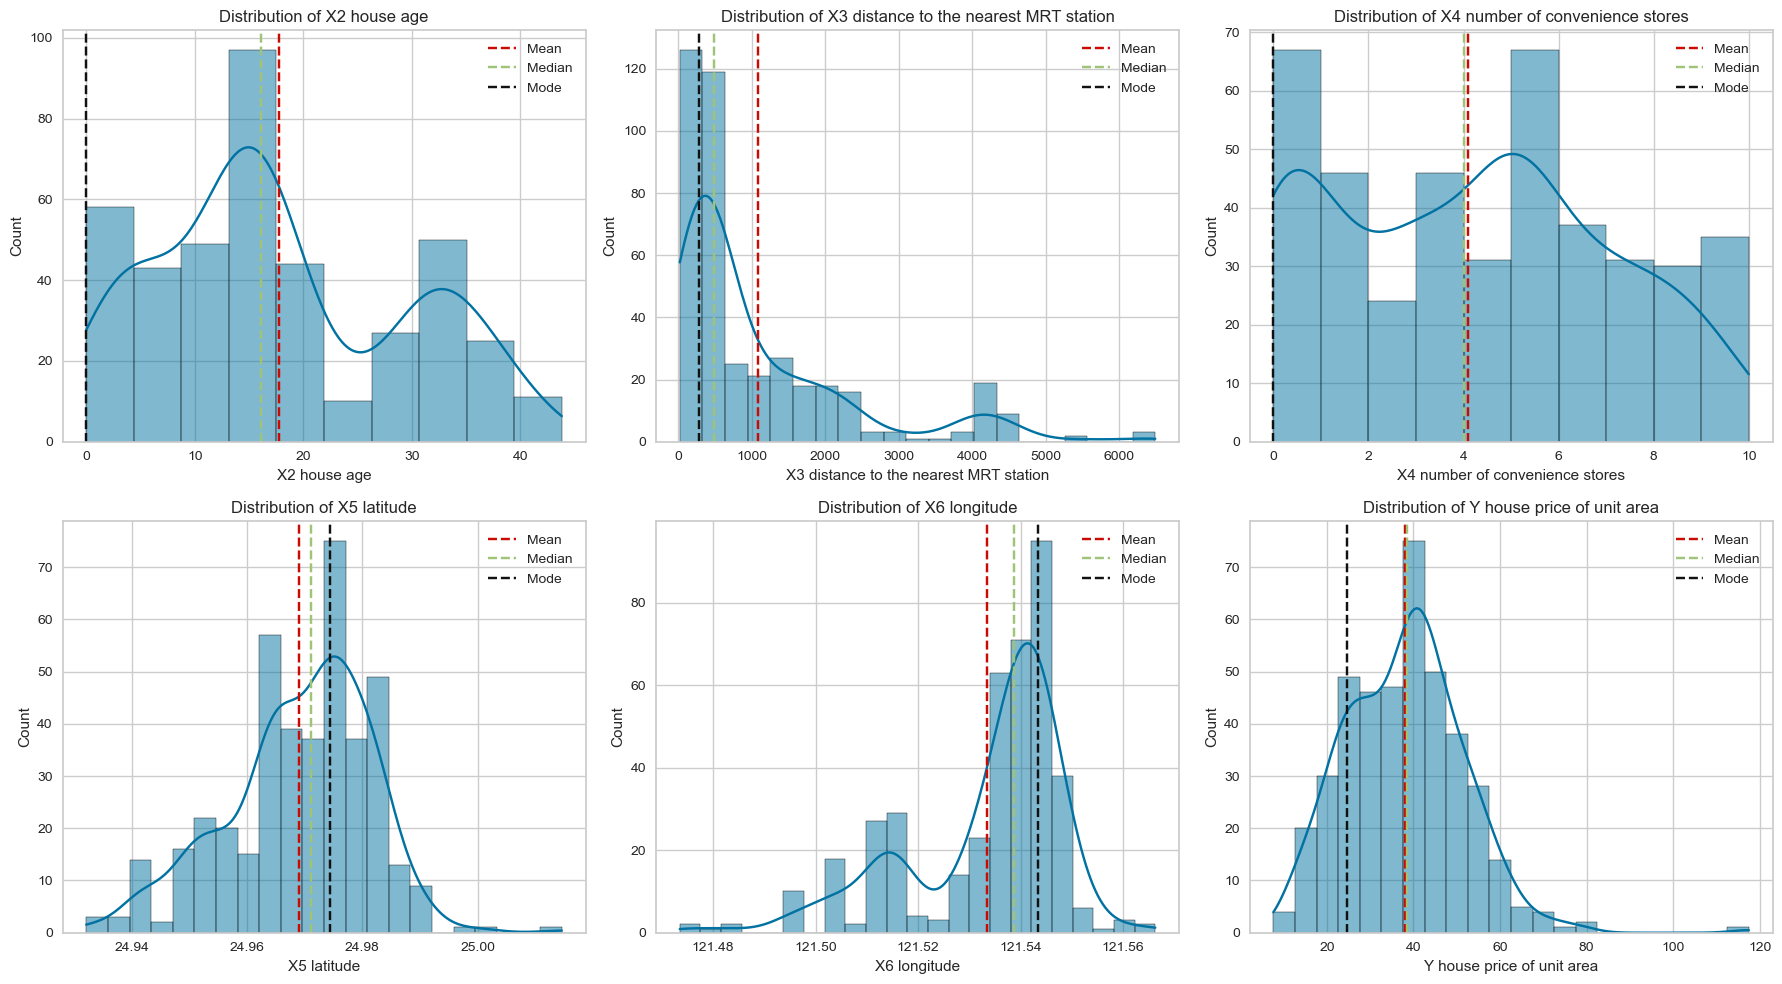

In [8]:
# Distribution of the columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Iterate over each column and plot the distribution
for i, col in enumerate(ds):
    sns.histplot(ds[col], kde=True, ax=axes[i])
    axes[i].axvline(ds[col].mean(), color='r', linestyle='--', label='Mean')
    axes[i].axvline(ds[col].median(), color='g', linestyle='--', label='Median')
    axes[i].axvline(ds[col].mode()[0], color='k', linestyle='--', label='Mode')  # Mode line
    axes[i].legend()
    axes[i].set_title(f"Distribution of {col}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

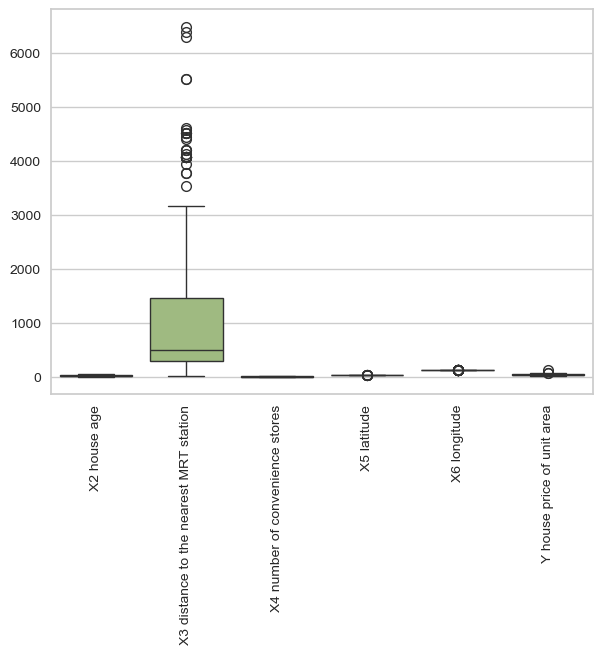

In [9]:
# Check outliers
plt.figure(figsize=(7,5))
sns.boxplot(data=ds)
plt.xticks(rotation=90)
plt.show()

<Figure size 600x500 with 0 Axes>

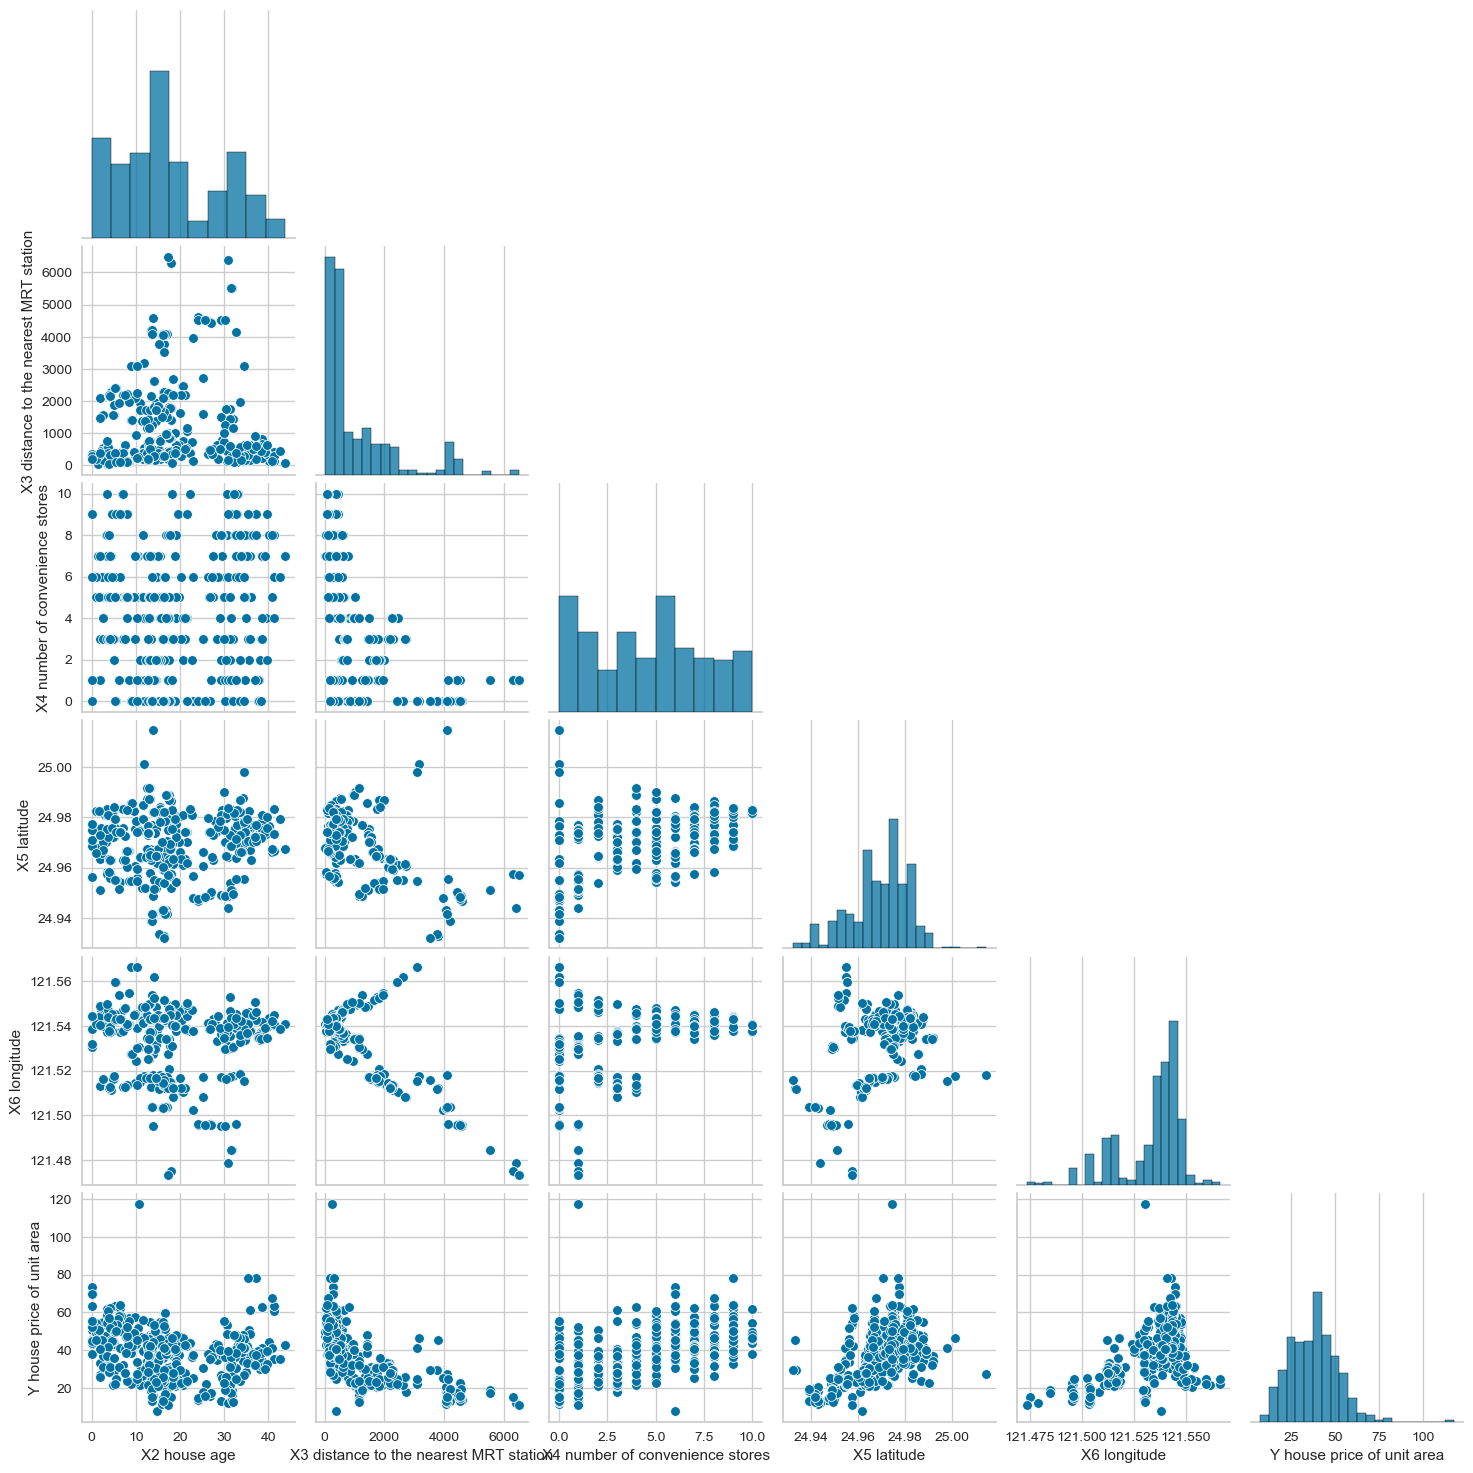

In [10]:
# Create a pairplot to see where there is potential linear relation between numerical features
plt.figure(figsize=(6, 5))
sns.pairplot(ds, corner=True)

plt.show()

In [11]:
# Create a modeling dataset from the original dataset to prevent data leakage. Apply data cleaning and preprocessing on the copied version
# Since the dataset is small and memory usage is not a concern, deep copy is applied
X = ds.copy(deep=True)
print(X.columns)

Index(['X2 house age', 'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')


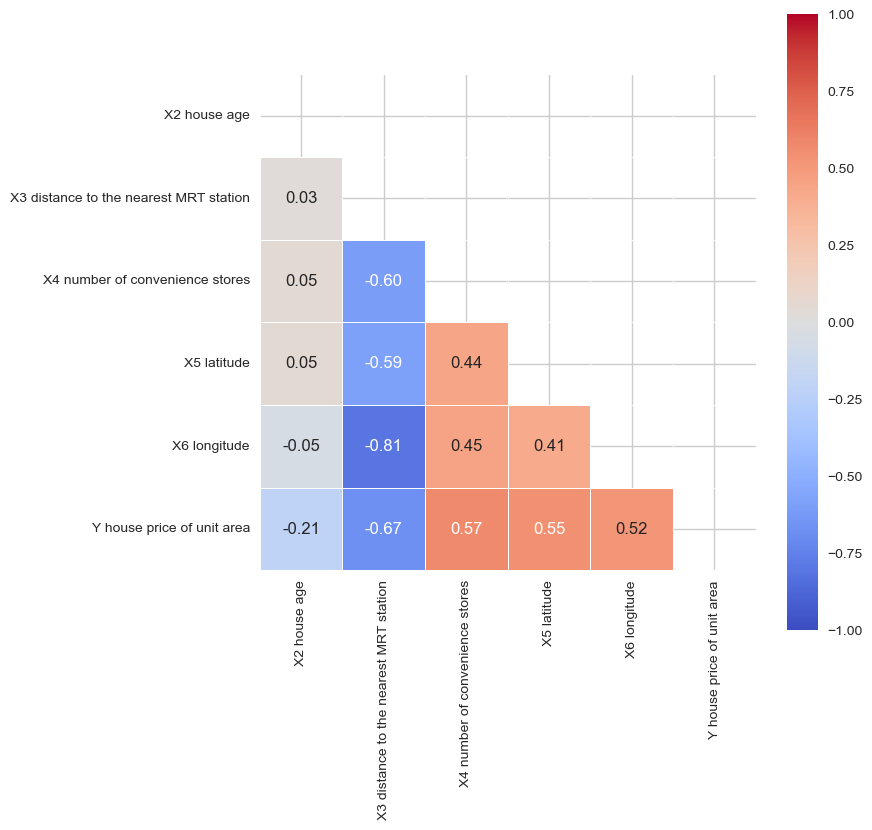

In [12]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the figure
plt.figure(figsize=(8, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask,
                square=True,
                linewidths=.5,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt=".2f")
plt.show()

In [13]:
# Create the target variable
y = X['Y house price of unit area']

In [14]:
# Confirm
print(y)

0      37.9
1      42.2
2      47.3
3      54.8
4      43.1
       ... 
409    15.4
410    50.0
411    40.6
412    52.5
413    63.9
Name: Y house price of unit area, Length: 414, dtype: float64


In [15]:
# Drop the target column 
X = X.drop(['Y house price of unit area'], axis=1)

In [16]:
# Confirm
print(X.columns)

Index(['X2 house age', 'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude'],
      dtype='object')


In [17]:
# Split the data into train and test
# Assigned random state for reproducebility
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=2024)

In [18]:
# Confirm
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(310, 5)
(104, 5)
(310,)
(104,)


In [19]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators',50, 100),
        'max_depth': trial.suggest_int('max_depth', 2,3),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    # Create a RandomForest regressor with trial parameters
    rf_reg = RandomForestRegressor(random_state=2024, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=10, shuffle=True, random_state=2024)
    cv_score = cross_val_score(rf_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_rf = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_rf)
print("Best R-squared Score:", best_score)

[I 2024-04-18 13:38:51,137] A new study created in memory with name: no-name-c0080763-1b16-476a-ba18-6cafc453b831
[I 2024-04-18 13:38:51,497] Trial 0 finished with value: 0.6909848131475075 and parameters: {'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6909848131475075.
[I 2024-04-18 13:38:51,822] Trial 1 finished with value: 0.6928002177554764 and parameters: {'n_estimators': 86, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6928002177554764.
[I 2024-04-18 13:38:52,182] Trial 2 finished with value: 0.6934736302566087 and parameters: {'n_estimators': 96, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.6934736302566087.
[I 2024-04-18 13:38:52,382] Trial 3 finished with value: 0.6493958057634399 and parameters: {'n_estimators': 56, 'max_depth': 2, 'min_sampl

Best Parameters: {'n_estimators': 96, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best R-squared Score: 0.6951924834468326


In [20]:
# Instantiate a RF model with parameters
rf_reg = RandomForestRegressor(**best_params_rf, random_state=2024)

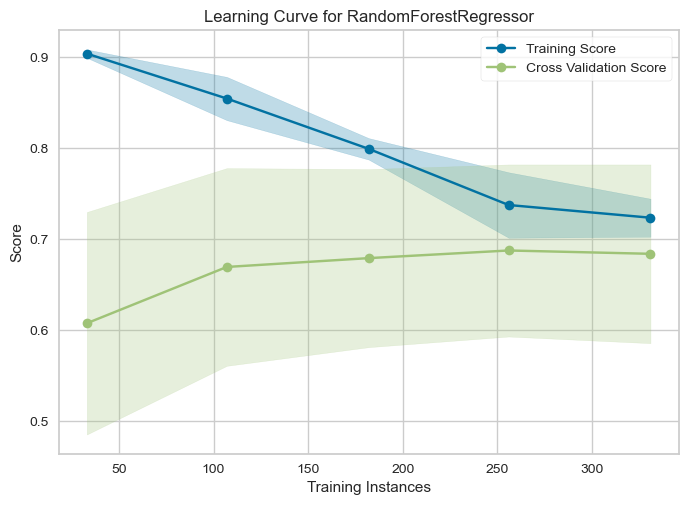

<Axes: title={'center': 'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [21]:
# Visualize learning curve
visualizer = LearningCurve(rf_reg, scoring='r2')

visualizer.fit(X, y)        
visualizer.show()          

In [22]:
# Fit the model to the training data
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, max_features='log2', n_estimators=96,
                      random_state=2024)

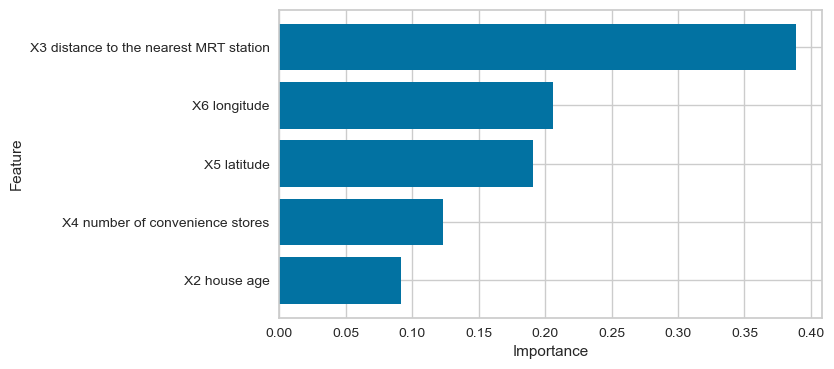

In [23]:
# Get feature names
feature_names = X.columns

# Sort feature importances in ascending order
sorted_indices = np.argsort(rf_reg.feature_importances_)
sorted_feature_names = feature_names[sorted_indices]
sorted_importances = rf_reg.feature_importances_[sorted_indices]

# Plot sorted feature importances
plt.figure(figsize=(7, 4))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [24]:
# Evaluate RandomForestRegressor and compare train and test results
evaluate_model(rf_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0053 |       0.0053 |
+--------------------+---------------+--------------+
| MAE                |        4.7586 |       5.1412 |
+--------------------+---------------+--------------+
| RMSE               |        7.2665 |       7.1293 |
+--------------------+---------------+--------------+
| R^2                |        0.7330 |       0.6505 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.7286 |       0.6327 |
+--------------------+---------------+--------------+
| MAPE               |       13.4501 |      17.8861 |
+--------------------+---------------+--------------+
| Max Error          |       65.0183 |      30.3826 |
+--------------------+---------------+--------------+


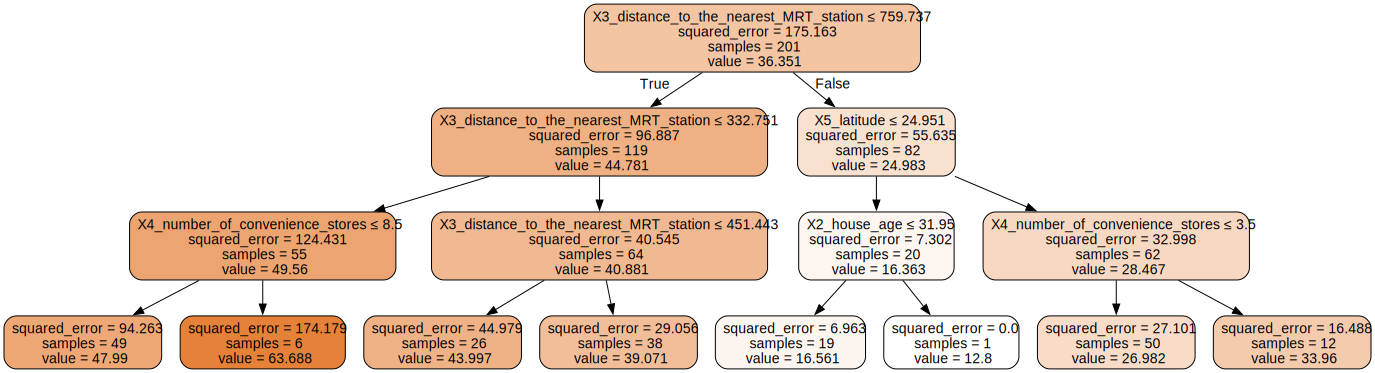

In [25]:
# Accessing one of the decision trees from the random forest
tree_in_forest = rf_reg.estimators_[4]

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_forest, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("random_forest_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


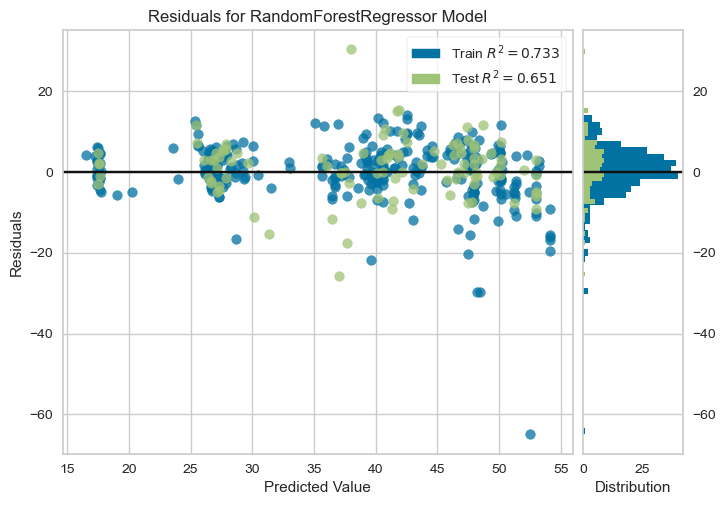

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [26]:
# Visualize residuals
visualizer = ResidualsPlot(rf_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

/Users/emrecanduran/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


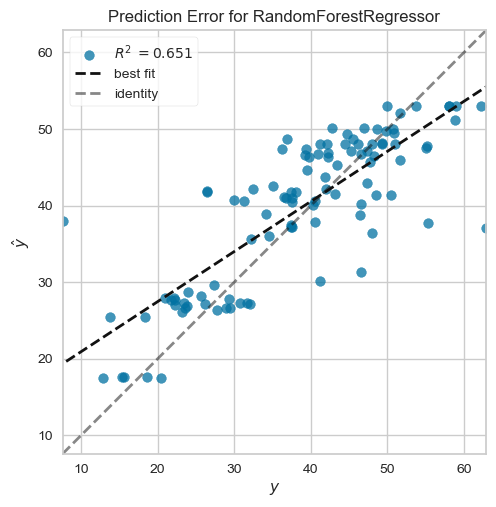

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [27]:
# Visualize prediction error
visualizer = PredictionError(rf_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

In [28]:
# Save the model 
pickle.dump(rf_reg, open('regmodel.pkl','wb'))